In [773]:
from models import NW   
from loaders import load_breast_cancer
import torch
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2


import pandas as pd

from pathlib import Path
pd.read_csv(Path('..') / 'data' / 'breast_cancer_train_indices.csv')


,train_idx
0,415
1,463
2,179
3,526
4,195
...,...
393,448
394,332
395,132
396,254


In [770]:
import torch.nn as nn
import torch.nn.functional as F

# A relu network with a single hidden layer, with a 1-dimensional input and output
class SimpleNet(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, hidden_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [771]:
# A dense layer
class Dense(nn.Module):
    def __init__(self, input_dim, output_dim, activation=torch.tanh):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        return self.activation(x)

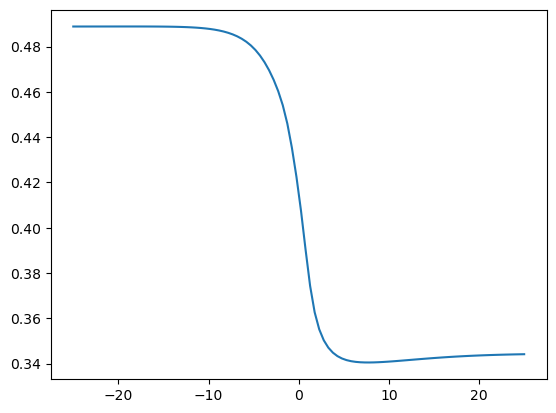

In [757]:
#torch.manual_seed(133742)
# model = SimpleNet(hidden_dim=5)
model = nn.Sequential(Dense(1,10), Dense(10,5), Dense(5,1), nn.Sigmoid())
# print(model)

# plot model(x) for x in [-5, 5]
x = torch.linspace(-25, 25, 100).view(-1, 1)
y = model(x)
plt.plot(x, y.detach().numpy())

In [775]:
X_train, y_train, X_test, y_test = load_breast_cancer()

# Make X data float
X_train = X_train.float()
X_test = X_test.float()

y_train = y_train.view(-1, 1)
y_test = y_test.view(-1, 1)

# select radius_mean
# X_train = X_train[:, 0].view(-1, 1).float()
# X_test = X_test[:, 0].view(-1, 1).float()

<AxesSubplot: >

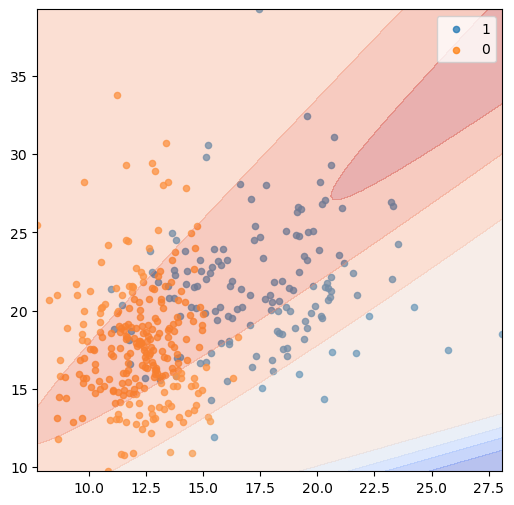

In [761]:
from helpers import train, plot_decision_bounary

# model = nn.Sequential(SimpleNet(input_dim=2, hidden_dim=10), nn.Sigmoid())
model = nn.Sequential(Dense(2,10),  Dense(10,1), nn.Sigmoid())
plot_decision_bounary(model, X_train, y_train)

0.3910209536552429

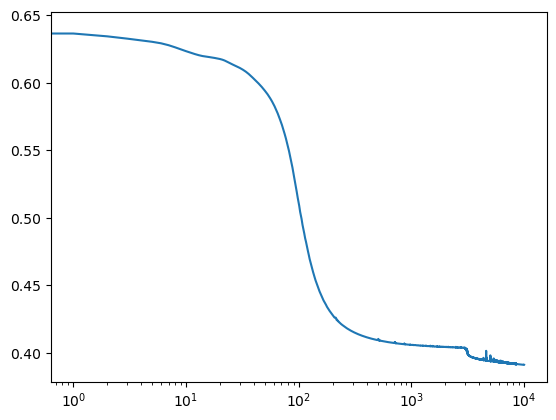

In [846]:
from helpers import gd_with_momentum2

# torch.manual_seed(133)
# torch.manual_seed(42)
torch.manual_seed(8493)

# model = SimpleNet(input_dim=2, hidden_dim=10)
# model = nn.Linear(2, 1)
# Set the weights to 0
# model.weight.data.fill_(0)
# model.bias.data.fill_(0)

model = nn.Sequential(Dense(2,10),  Dense(10,1))
# model = nn.Sequential(Dense(2,10),  Dense(10,10), Dense(10,1))
# model = nn.Sequential(Dense(2,10, torch.relu),  Dense(10, 1, torch.relu))

list(model.parameters())

def log_loss(model):
     # z = model(X_train).view(-1)
     
     # Sample X_train and y_train
     # idx = torch.randint(0, X_train.shape[0], (50,))
     # X_train_sample = X_train[idx]
     # y_train_sample = y_train[idx]
     X_train_sample = X_train
     y_train_sample = y_train

     z = model(X_train_sample)
     return torch.mean(-y_train_sample * z + torch.log(1 + torch.exp(z)))

# loss_hist = gd_with_momentum2(model, log_loss, momentum=0.9, lr=0.04, n_steps=10000)
# loss_hist = train(model, log_loss, n_steps=20000, lr=5e-3, momentum=0.8)

loss_hist = train(model, log_loss, n_steps=10000, lr=1e-2, optimizer=torch.optim.Adam)

# # loss_hist = train(model, F.binary_cross_entropy_with_logits, 1000, lr=0.01)

plt.plot(loss_hist)
# log axis
plt.xscale('log')
loss_hist[-1]

<AxesSubplot: >

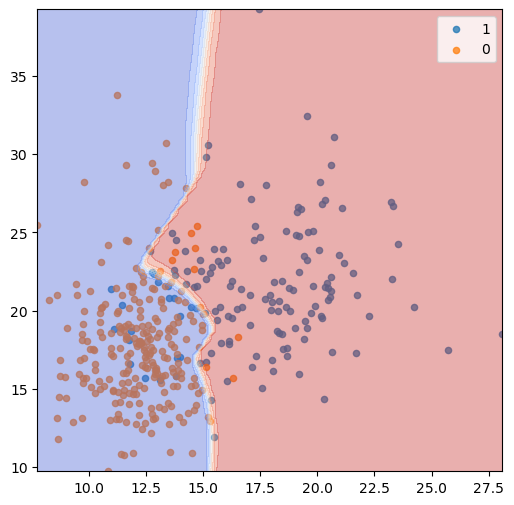

In [847]:
@torch.no_grad()
def wrapped_model(X):
    return torch.sigmoid(model(X))

plot_decision_bounary(wrapped_model, X_train, y_train)

In [744]:
# accuracy on the test set
with torch.no_grad():
    y_pred = wrapped_model(X_test)
    y_pred = (y_pred > 0.5).float()
    print((y_pred == y_test).float().mean())

tensor(0.9006)


In [745]:
# print model parameters named
for name, param in model.named_parameters():
    print(name, param)


0.fc.weight Parameter containing:
tensor([[ 0.3063,  0.0618],
        [ 0.3668, -0.0092],
        [-0.1967,  0.0398],
        [-0.5216, -0.5573],
        [-0.6826, -0.4337],
        [-0.2900,  0.6766],
        [ 0.1747,  0.4972],
        [ 0.1915, -0.0506],
        [-0.0965, -0.1153],
        [ 0.4226,  0.3574]], requires_grad=True)
0.fc.bias Parameter containing:
tensor([ 0.2661,  0.3724,  1.8539,  0.3230,  0.2445, -0.6039,  0.0807, -1.4491,
         3.3357, -0.2038], requires_grad=True)
1.fc.weight Parameter containing:
tensor([[-0.2545, -0.4210, -2.5007,  0.5236,  0.3662, -0.3596, -0.2380,  1.9649,
         -3.7951, -0.2664]], requires_grad=True)
1.fc.bias Parameter containing:
tensor([-0.0618], requires_grad=True)
